# Generate Yeo Functional Connectivity
This script generates functional connectivites based on the Yeo 2011 parcellation.

## Get Yeo FPN + DMN subregion coordinates

In [21]:
from os import listdir, makedirs
from os.path import isfile, join, exists
import time

from nilearn import plotting, image, datasets
from nilearn.input_data import NiftiSpheresMasker, NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
from nilearn.regions import connected_label_regions
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [3]:
aa_folder = 'BioBank_Analysis/'
saveresids_folder = 'aamod_firstlevel_modelestimate_saveresids_00001/'
python_fc_folder = 'python_yeo_fc'


Dataset created in /home/bpho/nilearn_data/yeo_2011



 ...done. (1 seconds, 0 min)
Extracting data from /home/bpho/nilearn_data/yeo_2011/a2fde1b0e3db25e49d233ec6cf6ada04/Yeo_JNeurophysiol11_MNI152.zip..... done.


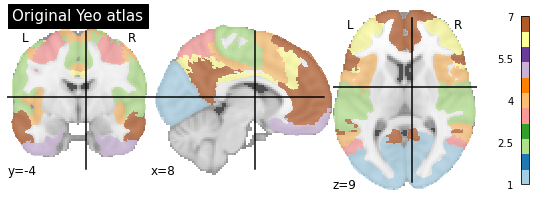

In [2]:
yeo = datasets.fetch_atlas_yeo_2011()['thick_7']

plotting.plot_roi(yeo, title='Original Yeo atlas',
                  cut_coords=(8, -4, 9), colorbar=True, cmap='Paired')

(256, 256, 256, 1) (256, 256, 256, 1)
(array([0, 6]), array([16621877,   155339]))
(array([0, 7]), array([16536238,   240978]))


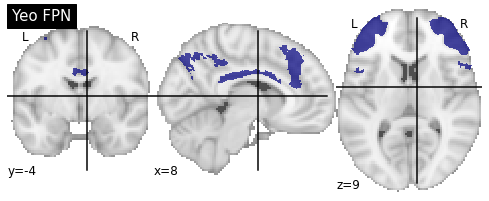

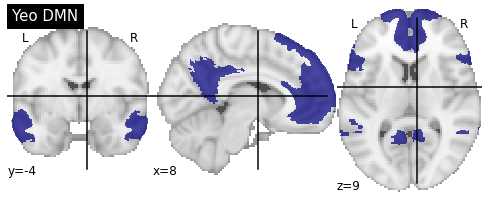

In [3]:
# Convert the Yeo image into a NumPy array and filter the array for
# values where 6 = FPN and 7 = DMN. Must do this because Nilearn has
# no function to grab the networks.
yeo_np = image.get_data(yeo).astype(np.int)
fpn = np.where(yeo_np == 6, yeo_np, 0)
dmn = np.where(yeo_np == 7, yeo_np, 0)
print(fpn.shape, dmn.shape)
print(np.unique(fpn, return_counts=True))
print(np.unique(dmn, return_counts=True))

yeo_fpn = image.new_img_like(yeo, fpn)
yeo_dmn = image.new_img_like(yeo, dmn)

plotting.plot_roi(yeo_fpn, title='Yeo FPN', cut_coords=(8, -4, 9))
plotting.plot_roi(yeo_dmn, title='Yeo DMN', cut_coords=(8, -4, 9))

In [82]:
# Combine both networks and calculate new regions for each network
# based on adjacent voxels. In other words, it finds islands of regions
# that are disconnected (aka not adjacent).
# fpn_dmn = fpn + dmn
fpn_dmn = fpn + dmn
yeo_fpn_dmn = image.new_img_like(yeo, fpn_dmn)
subregions, subregion_labels = connected_label_regions(
    yeo_fpn_dmn, min_size=500, labels=["FPN", "DMN"])
unique, counts = np.unique(subregion_labels, return_counts=True)

# Rename labels to be more informative
current_subregion = subregion_labels[0]
current_counter = 1
for index, subregion in enumerate(subregion_labels):
    # When we're finished relabeling DMN, reset counter for FPN
    if subregion != current_subregion:
        current_subregion = subregion
        current_counter = 1
    
    # Rename the subregion and increment the counter
    subregion_labels[index] = f"{subregion}_{current_counter}"
    current_counter += 1

print("Original networks:", unique)
print("Num new regions per network:", counts)
print("Num new regions:", len(subregion_labels))
# print(subregion_labels)

Original networks: ['DMN' 'FPN']
Num new regions per network: [ 8 11]
Num new regions: 19


/home/bpho/.conda/envs/venv/lib/python3.7/site-packages/nilearn/image/resampling.py:512: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))



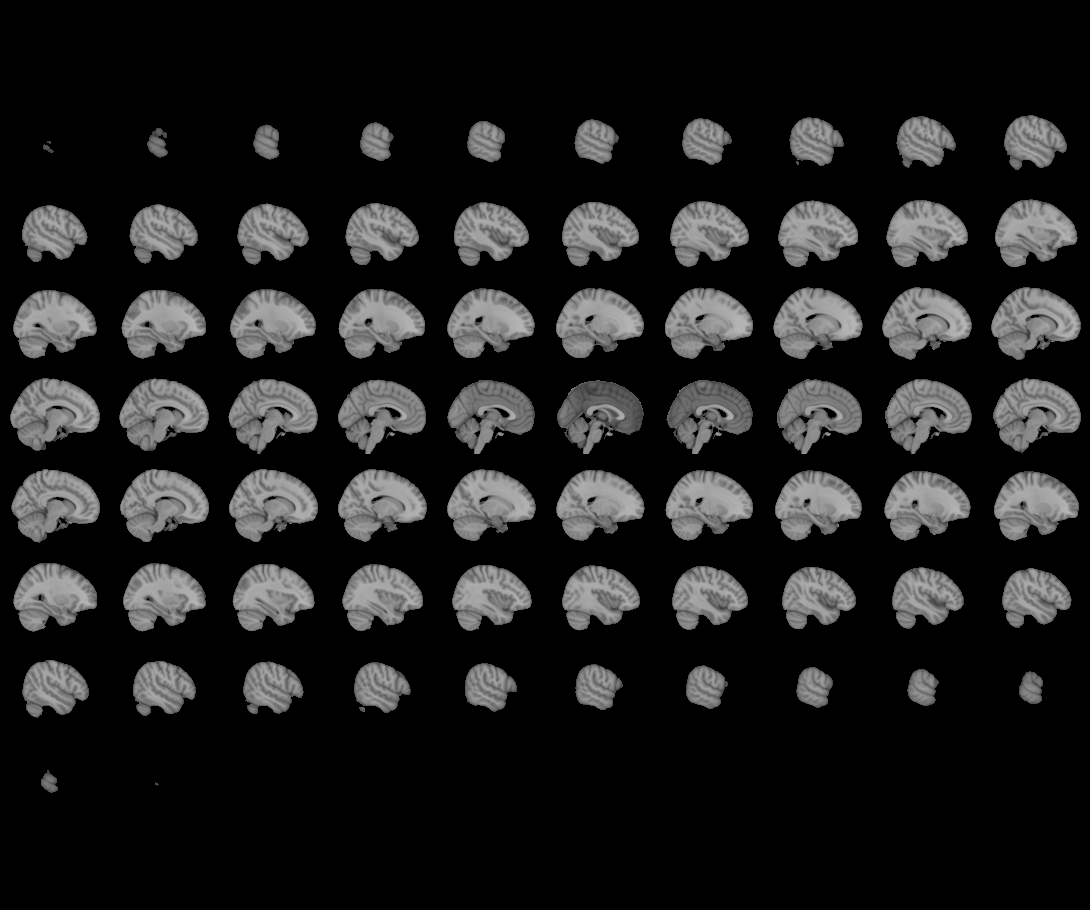
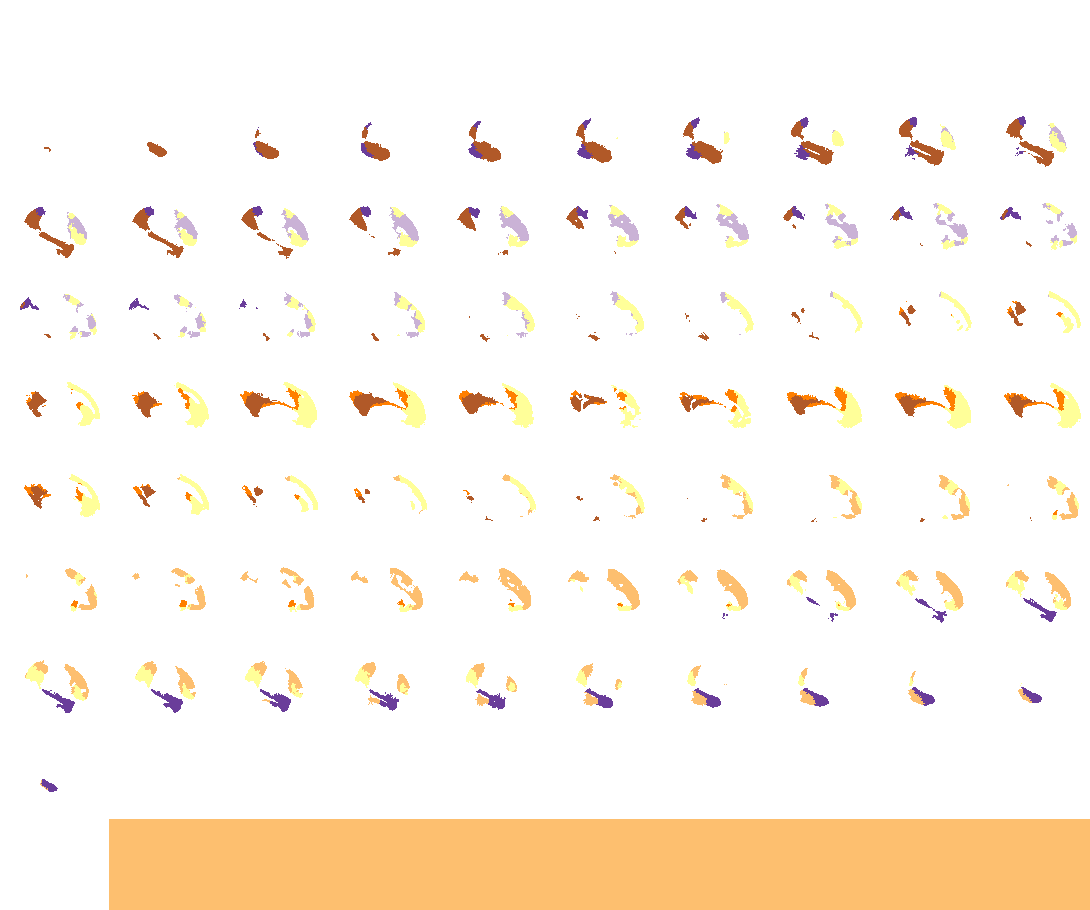

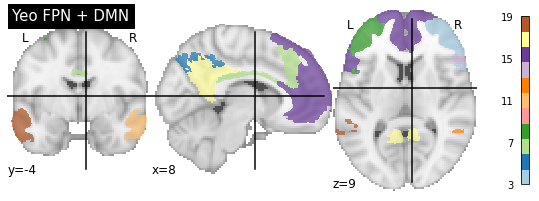

In [89]:
# Plot all subregions
plotting.plot_roi(subregions, title='Yeo FPN + DMN',
                  cut_coords=(8, -4, 9), colorbar=True, cmap='Paired')

# Interaction version
plotting.view_img(subregions, title='Yeo FPN + DMN',
                  cut_coords=(8, -4, 9), colorbar=True, cmap='Paired')

In [97]:
# Map each label to each subregion
label_to_subregion = {}

for region_num in range(1, 20):
    subregion = np.where(subregions_np == region_num, subregions_np, 0)
    label = subregion_labels[region_num - 1]  # Subtract 1 because index starts at 0
    label_to_subregion[label] = subregion

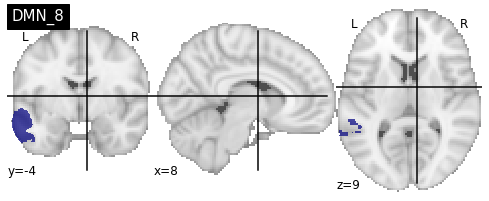

In [98]:
# Plot a specific subregion (given the label)
subregions_np = image.get_data(subregions).astype(np.int)

selected_subregion_label = "DMN_8"
selected_subregion = image.new_img_like(
    yeo, label_to_subregion[selected_subregion_label])
plotting.plot_roi(selected_subregion, title=selected_subregion_label, 
                  cut_coords=(8, -4, 9))

In [99]:
# Convert the subregions into coordinates using the region's center
subregion_coords = plotting.find_parcellation_cut_coords(subregions)
print(subregion_coords.shape)

# subregion_label_to_coords = {}
# for label, coord in zip(subregion_labels, subregion_coords):
#     subregion_label_to_coords[label] = coord

# print("Num regions:", len(subregion_label_to_coords))

(19, 3)


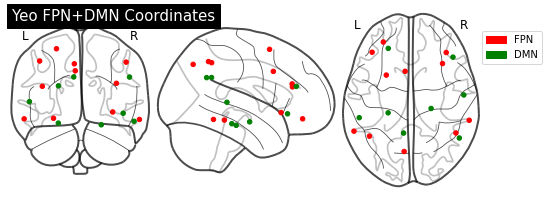

In [78]:
subregion_label_colors = []
for label in subregion_labels:
    if label.startswith('FPN'):
        subregion_label_colors.append('red')
    else:
        subregion_label_colors.append('green')

plot_connect = plotting.plot_connectome(
    np.zeros((19, 19)), subregion_coords, subregion_label_colors, 
    title='Yeo FPN+DMN Coordinates', node_size=20, annotate=True)
red_patch = mpatches.Patch(color='red', label='FPN')
blue_patch = mpatches.Patch(color='green', label='DMN')
plt.legend(handles=[red_patch, blue_patch], loc=(1, 0.7))
# plotting.view_markers(subregion_coords, title='', marker_size=3)

In [36]:
scratch_dir = "/home/bpho/Documents/MSc_Research-Project/scratch_data"
np.save(f"{scratch_dir}/subregion_coords.npy", subregion_coords)
np.save(f"{scratch_dir}/subregion_labels.npy", subregion_labels)

## Generate subregion FC

In [54]:
aa_folder = 'BioBank_Analysis/'
saveresids_folder = 'aamod_firstlevel_modelestimate_saveresids_00001/'
python_fc_folder = 'python_yeo_fc'

In [38]:
spheres_masker = NiftiSpheresMasker(
    seeds=subregion_coords, smoothing_fwhm=6, radius=5., 
    standardize=True)

def generate_yeo_fc(file):
    time_series = spheres_masker.fit_transform(file)
    
    correlation_measure = ConnectivityMeasure(kind='correlation')
    correlation_matrix = correlation_measure.fit_transform([time_series])[0]
    
    return correlation_matrix

In [39]:
def visualize_corr_matrix(corr_matrix):
    np.fill_diagonal(corr_matrix, 0)
    plotting.plot_matrix(corr_matrix, vmin=-1., vmax=1., colorbar=True, figure=(10, 10),
                     title='Yeo correlation matrix', labels=subregion_labels)
    plotting.plot_connectome(corr_matrix, subregion_coords, title='Yeo correlation graph',
                         edge_threshold='80%', node_size=20, colorbar=True)

In [55]:
for age in range(7, 16):
    print("Processing age:", age)
    age_dir = f'/imaging2/owenlab/wilson/MovieData/Age{age}'

    input_path = join(age_dir, aa_folder, saveresids_folder)
    output_path = join(age_dir, aa_folder, python_fc_folder)

    # Grab all subjects
    subjects = [folder for folder in listdir(input_path) if folder.startswith("sub-")]

    for subject in subjects:
        print("  Processing subject:", subject)
        start_time = time.time()
        subject_input_path = join(input_path, subject)
        subject_output_path = join(output_path, subject)

        # Check if we've already generated the FC for this subject
        if exists(subject_output_path):
            print("    Skipping subject due to already generated FC.")
            continue

        subject_niftis = [join(subject_input_path, f) for f in listdir(subject_input_path) 
                          if isfile(join(subject_input_path, f)) and f.startswith('ResI')]

        if len(subject_niftis) != 745:
            print("    Incomplete subject niftis:", len(subject_niftis))
            continue

        subject_concat_image = image.concat_imgs(subject_niftis)
        subject_corr_matrix = generate_yeo_fc(subject_concat_image)

        makedirs(subject_output_path)
        subject_corr_filename = join(subject_output_path, 'yeo_fc.npy')
        np.save(subject_corr_filename, subject_corr_matrix)
        print("    Time elapsed:", time.time() - start_time)
        # visualize_corr_matrix(subject_corr_matrix)

Processing age: 7
  Processing subject: sub-NDARFD453NPR
    Skipping subject due to already generated FC.
  Processing subject: sub-NDARFV685ZT2
    Time elapsed: 90.23894810676575
  Processing subject: sub-NDAREK575JNM
    Time elapsed: 102.40177130699158
  Processing subject: sub-NDARFM229HHA
    Time elapsed: 104.06748294830322
  Processing subject: sub-NDARDA656RBN
    Time elapsed: 103.81743359565735
  Processing subject: sub-NDARMY294VNE
    Time elapsed: 103.61679291725159
  Processing subject: sub-NDARJC399UW7
    Time elapsed: 116.11893582344055
  Processing subject: sub-NDARHD931FNA
    Time elapsed: 103.03391885757446
  Processing subject: sub-NDARFT787HJW
    Time elapsed: 115.4847207069397
  Processing subject: sub-NDARDV245WJG
    Time elapsed: 103.05087971687317
  Processing subject: sub-NDARDF374LGN
    Time elapsed: 103.21749329566956
  Processing subject: sub-NDARPE752VYE
    Time elapsed: 113.38501858711243
  Processing subject: sub-NDARNN142WYB
    Time elapsed: 10

    Time elapsed: 104.48508214950562
  Processing subject: sub-NDARTP270UAV
    Time elapsed: 103.38397336006165
  Processing subject: sub-NDARHH819LH3
    Time elapsed: 101.7689278125763
  Processing subject: sub-NDARAU967RWU
    Incomplete subject niftis: 578
  Processing subject: sub-NDARYC243UW5
    Time elapsed: 101.58120512962341
  Processing subject: sub-NDARXZ902NFM
    Time elapsed: 102.90114450454712
  Processing subject: sub-NDARNK740ZVM
    Time elapsed: 106.95130181312561
  Processing subject: sub-NDARRM073JKA
    Time elapsed: 104.70214343070984
  Processing subject: sub-NDARVG761NR2
    Time elapsed: 104.60097670555115
  Processing subject: sub-NDARXP557DLJ
    Time elapsed: 102.11775088310242
  Processing subject: sub-NDARFB322DRA
    Time elapsed: 100.41759419441223
  Processing subject: sub-NDARRL426AD5
    Time elapsed: 100.4838285446167
  Processing subject: sub-NDARRX897XV1
    Time elapsed: 105.36706948280334
  Processing subject: sub-NDAREJ327AH7
    Time elapsed

    Time elapsed: 104.86750411987305
  Processing subject: sub-NDARYL758JGG
    Time elapsed: 107.71601009368896
  Processing subject: sub-NDARGJ395FKP
    Time elapsed: 106.08570647239685
  Processing subject: sub-NDARDR236FWH
    Incomplete subject niftis: 0
  Processing subject: sub-NDARLD738DUM
    Incomplete subject niftis: 245
  Processing subject: sub-NDARJH367WKY
    Time elapsed: 104.77082920074463
  Processing subject: sub-NDARAG115LZP
    Time elapsed: 101.73301792144775
  Processing subject: sub-NDARPC817XZ5
    Time elapsed: 105.94222712516785
  Processing subject: sub-NDARMV605LGH
    Time elapsed: 105.67624521255493
  Processing subject: sub-NDARKH171DG8
    Time elapsed: 107.75092601776123
  Processing subject: sub-NDARCU621EBN
    Time elapsed: 103.21850419044495
  Processing subject: sub-NDARPE056ACA
    Time elapsed: 108.01804804801941
  Processing subject: sub-NDARGR354WBH
    Time elapsed: 108.40149974822998
  Processing subject: sub-NDARUX408KJ1
    Time elapsed: 

## Powers Atlas (UNUSED)
Unused due to inability to convert from power coordinates to Yeo MNI space.

In [66]:
power = datasets.fetch_coords_power_2011()
coords = np.vstack((power.rois['x'], power.rois['y'], power.rois['z'])).T

[ 57 143 101]
[-71  15 -27]
(155339, 3)


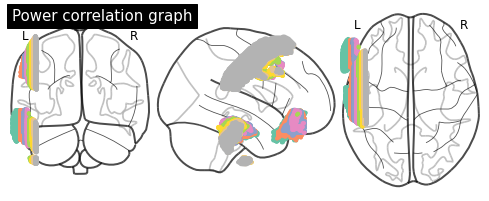

In [128]:
fpn = np.where(yeo_np == 6)
coords = np.vstack((fpn[0], fpn[1], fpn[2])).T
print(coords[0])
coords -= 128
print(coords[0])
print(coords.shape)
plotting.plot_connectome(np.zeros((30000, 30000)), coords[0:30000], title='Power correlation graph',
                         node_size=10)